In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier # model
from xgboost import plot_importance as xgb_plot_importance# 중요변수 시각화

from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, recall_score, f1_score, roc_auc_score,accuracy_score
from lightgbm import plot_importance
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter

from matplotlib import pyplot as plt
import seaborn as sns

from imblearn.under_sampling import *
from imblearn.over_sampling import *
from imblearn.over_sampling import SMOTE
%matplotlib inline


import warnings
warnings.filterwarnings(action='ignore')

# raw 데이터에 대한 원핫 인코딩 기반 모델
## 샘플링 적용 없음

In [2]:
df_onehot = pd.read_csv('onehot_encoding_data.csv').drop('Unnamed: 0',axis=1)
df_onehot

df_label = pd.read_csv('label_encoding_data.csv').drop('Unnamed: 0',axis=1)
df_onehot

,age,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,...,house_unknown,loan_no,loan_yes,loan_unknown,pdays,previous,pout_no,pout_yes,pout_unknown,y
0,56,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,-1,0,0.0,0.0,1.0,0
1,57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,-1,0,0.0,0.0,1.0,0
2,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,-1,0,0.0,0.0,1.0,0
3,40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,-1,0,0.0,0.0,1.0,0
4,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,-1,0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,-1,0,0.0,0.0,1.0,1
41184,46,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,-1,0,0.0,0.0,1.0,0
41185,56,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,-1,0,0.0,0.0,1.0,0
41186,44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,-1,0,0.0,0.0,1.0,1


### LightGBM 모델

In [44]:
# LightGBM 모델(별도 파라미터 조정 없음)

feature = df_onehot.loc[:,:'pout_unknown']
target = df_onehot['y']

X_test, X_train, y_test, y_train = train_test_split(feature,target,test_size=0.3,random_state=0)

model = LGBMClassifier()
model.fit(X_train,y_train)
ligt_gbm = model.predict(X_test)
predict_proba = model.predict_proba(X_test)

def score(a,b,c):
    confusion = confusion_matrix(a,b)
    accuracy = accuracy_score(a,b)
    precision = precision_score(a,b)
    recall = recall_score(a,b)
    f1 = f1_score(a,b)
    
    roc_auc = roc_auc_score(a,b)
    
    print('Confusion Matrix')
    print(confusion)
    print('accuracy: {}, precision: {}, recall: {}, f1: {}, roc_acu: {}'.format(accuracy,precision,recall,f1,roc_auc))
    return pd.DataFrame(index=['accuracy','precision','recall','f1','roc-acu'],data = [[accuracy],[precision],[recall],[f1],[roc_auc]],columns=[c])
    
score(y_test,ligt_gbm,'ligt_gbm')

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test,pd.DataFrame(predict_proba).loc[:,1])

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc

# threshold 최대값의 인덱스, np.argmax()
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)
predict = pd.DataFrame(predict_proba).loc[:,1]>= optimal_threshold
score(y_test,predict,'c')

Confusion Matrix
[[25242   337]
 [ 2663   589]]
accuracy: 0.8959453366168361, precision: 0.6360691144708424, recall: 0.18111931119311192, f1: 0.2819530876017233, roc_acu: 0.5839722205912782
idx: 1668 , threshold: 0.14950305301234793
Confusion Matrix
[[22347  3232]
 [ 1921  1331]]
accuracy: 0.8212687731955187, precision: 0.29169406092483013, recall: 0.40928659286592867, f1: 0.34062699936020474, roc_acu: 0.6414664716939206


,c
accuracy,0.821269
precision,0.291694
recall,0.409287
f1,0.340627
roc-acu,0.641466


In [34]:
pd.DataFrame(predict_proba).loc[:,1]
predict =  (pipe.predict_proba(X_test)[:,1] >= optimal_threshold)

0        0.026294
1        0.047091
2        0.009913
3        0.088330
4        0.042915
           ...   
28826    0.110897
28827    0.087850
28828    0.134530
28829    0.038327
28830    0.061604
Name: 1, Length: 28831, dtype: float64

In [4]:
# light gbm에 맞는 최적 파라미터 찾기

params= {
    'max_depth':[-1,5,10,15,20],
    'learning_rate':[0.01,0.05,0.1,0.3,0.5,0.7]   
}
grid_cv = GridSearchCV(model, param_grid=params, scoring='accuracy',cv=5, verbose=1)
grid_cv.fit(X_train,y_train)
# grid_cv.predit(X_test)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
                         'max_depth': [-1, 5, 10, 15, 20]},
             scoring='accuracy', verbose=1)

In [5]:
grid_cv.best_score_
grid_cv.best_params_

{'learning_rate': 0.05, 'max_depth': 15}

In [6]:
# lightgbm 최적 파라미터 모델

feature = df_onehot.loc[:,:'pout_unknown']
target = df_onehot['y']

X_test, X_train, y_test, y_train = train_test_split(feature,target,test_size=0.3,random_state=0)

model = LGBMClassifier(learning_rate=0.05,max_depth=20)
model.fit(X_train,y_train)
ligt_gbm_2 = model.predict(X_test)
predict_proba = model.predict_proba(X_test)

score(y_test,ligt_gbm_2,'ligt_gbm_2')

Confusion Matrix
[[25294   285]
 [ 2702   550]]
accuracy: 0.8963962401581631, precision: 0.6586826347305389, recall: 0.16912669126691268, f1: 0.2691460729141179, roc_acu: 0.5789923694420493


,ligt_gbm_2
accuracy,0.896396
precision,0.658683
recall,0.169127
f1,0.269146


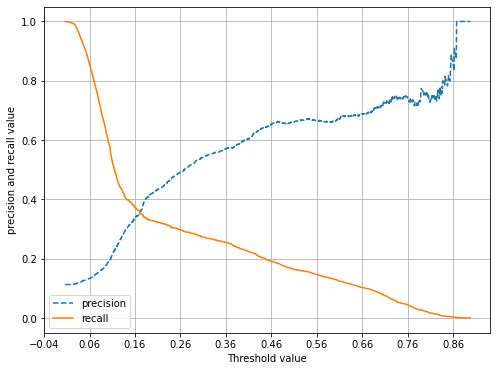

In [7]:
proba = model.predict_proba(X_test)


#임계값 변경에 따른 최적 모델의 정밀도-재현율 변화 곡선
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def precision_recall_curve_plot(y_test,proba):
    precisions, recalls, thresholds = precision_recall_curve(y_test,proba)
    
    plt.figure(figsize=(8,6))
    threshold_boundary =thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision'
            )
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    
    plt.xlabel('Threshold value');plt.ylabel('precision and recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test,proba[:,1])

In [8]:
# 임계값 교차점의 f1score

y_proba = model.predict_proba(X_test)

for i in np.arange(len(y_proba)):
    if y_proba[i][1] >= 0.16:
        y_proba[i][1] = 1
    else:
        y_proba[i][1] = 0


accuracy = accuracy_score(y_test,y_proba[:,1])
f1 = f1_score(y_test,y_proba[:,1])
precision = precision_score(y_test,y_proba[:,1])
recall = recall_score(y_test,y_proba[:,1])
print('accuracy: {}, f1: {}, precision: {}, recall: {}'.format(accuracy,f1,precision,recall))

accuracy: 0.8478027123582256, f1: 0.3554641598119859, precision: 0.34026996625421824, recall: 0.3720787207872079


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

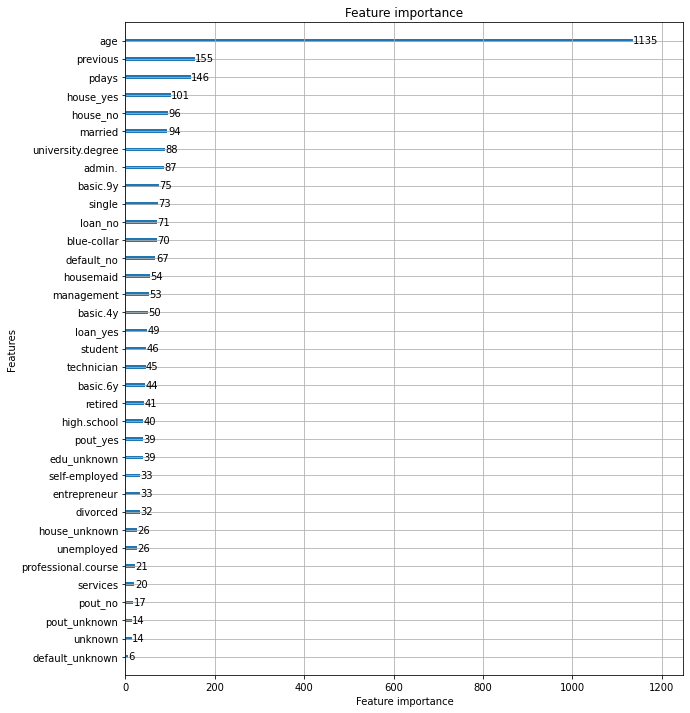

In [9]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(model, ax=ax)

In [10]:
print(f'기존 통화 건수:{len(y_test)}, 예측 모형 후 통화 건수:{ligt_gbm_2.sum()}')
print(f'기존 마케팅 성공 횟수: {y_test.sum()}, 예측 모형 후 성공 횟수: 560')
# print(f'기존 마케팅 성공 확률:{np.round(3252/28831,2)}, 예측 모형 후 성공 확률:{np.round}')

기존 통화 건수:28831, 예측 모형 후 통화 건수:835
기존 마케팅 성공 횟수: 3252, 예측 모형 후 성공 횟수: 560


### XGBoost 모델

In [11]:
feature = df_onehot.loc[:,:'pout_unknown']
target = df_onehot['y']

model= XGBClassifier(n_estimators=500, learning_rate = 0.1, max_depth = 4)
model.fit(X_train, y_train)
xgb_1 = model.predict(X_test)

score(y_test,xgb_1,'xgb_1')

Confusion Matrix
[[25215   364]
 [ 2679   573]]
accuracy: 0.8944538864416773, precision: 0.6115261472785486, recall: 0.17619926199261993, f1: 0.27357364526139893, roc_acu: 0.5809844192992147


,xgb_1
accuracy,0.894454
precision,0.611526
recall,0.176199
f1,0.273574


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

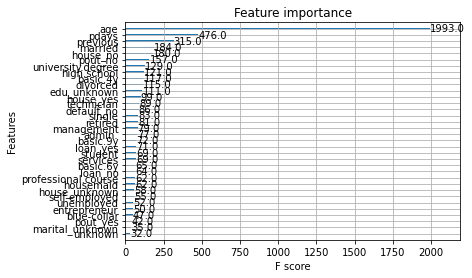

In [12]:
fig, ax = plt.subplots()
xgb_plot_importance(model, ax=ax)

In [13]:
model = XGBClassifier(n_estimators=400, learning_rate = 0.1, max_depth = 5)
evals = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds = 200, eval_metric = "logloss", eval_set = evals, verbose = 0)

xgb_2 = model.predict(X_test)

score(y_test,xgb_2,'xgb_2')

Confusion Matrix
[[25301   278]
 [ 2713   539]]
accuracy: 0.8962575006069855, precision: 0.6597307221542228, recall: 0.16574415744157442, f1: 0.26492995822069304, roc_acu: 0.5774379335235551


,xgb_2
accuracy,0.896258
precision,0.659731
recall,0.165744
f1,0.264930


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

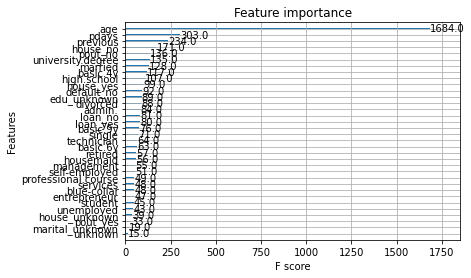

In [14]:
fig, ax = plt.subplots()
xgb_plot_importance(model, ax=ax)

## raw 데이터에 대한 샘플링 방식적용(언더, 오버, smote) 원핫 인코딩 기반 모델
### 언더방식

In [15]:
#### LightGBM모델
import matplotlib.pyplot as plt
import seaborn as sns

feature = df_onehot.loc[:,:'pout_unknown']
target = df_onehot['y']

X_test, X_train, y_test, y_train = train_test_split(feature,target,test_size=0.3,random_state=0)


undersample = RandomUnderSampler(sampling_strategy='majority')


X_under, y_under = undersample.fit_resample(feature, target)
print(Counter(y_under))




model = LGBMClassifier(n_estimators=500)
model.fit(X_under,y_under)
y_pred = model.predict(X_test)
predict_proba = model.predict_proba(X_test)

score(y_test,y_pred,'under_lightgbm')


Counter({0: 4640, 1: 4640})
Confusion Matrix
[[18749  6830]
 [ 1009  2243]]
accuracy: 0.7281051645797926, precision: 0.24721701752452332, recall: 0.689729397293973, f1: 0.36397565922920894, roc_acu: 0.7113567429020395


,under_lightgbm
accuracy,0.728105
precision,0.247217
recall,0.689729
f1,0.363976


In [16]:
#### XGBoost 모델
model= XGBClassifier(n_estimators=500, learning_rate = 0.1, max_depth = 4)
model.fit(X_under, y_under)
xgb_1 = model.predict(X_test)

score(y_test,xgb_1,'under_xgb')

Confusion Matrix
[[20648  4931]
 [ 1556  1696]]
accuracy: 0.7749991328778051, precision: 0.25592274030481366, recall: 0.5215252152521526, f1: 0.3433545905456018, roc_acu: 0.664374945872294


,under_xgb
accuracy,0.774999
precision,0.255923
recall,0.521525
f1,0.343355


### 오버 방식

In [17]:
#### LightGBM모델

import matplotlib.pyplot as plt
import seaborn as sns

feature = df_onehot.loc[:,:'pout_unknown']
target = df_onehot['y']

X_test, X_train, y_test, y_train = train_test_split(feature,target,test_size=0.3,random_state=0)


oversample = RandomOverSampler(sampling_strategy='minority')



X_over, y_over = oversample.fit_resample(X_train, y_train)





model = LGBMClassifier(n_estimators=500)
model.fit(X_over,y_over)
y_pred = model.predict(X_test)
predict_proba = model.predict_proba(X_test)

score(y_test,y_pred,'over_lightgbm')


Confusion Matrix
[[20093  5486]
 [ 1891  1361]]
accuracy: 0.7441295827407999, precision: 0.1987731853366438, recall: 0.41851168511685116, f1: 0.26953163679572234, roc_acu: 0.602019437695061


,over_lightgbm
accuracy,0.744130
precision,0.198773
recall,0.418512
f1,0.269532


In [18]:
#### XGBoost 모델

model= XGBClassifier(n_estimators=500, learning_rate = 0.1, max_depth = 4)
model.fit(X_over, y_over)
xgb_1 = model.predict(X_test)

score(y_test,xgb_1,'over_xgb')

Confusion Matrix
[[19603  5976]
 [ 1667  1585]]
accuracy: 0.7349034025874926, precision: 0.20962835603756116, recall: 0.48739237392373924, f1: 0.29316563395912326, roc_acu: 0.6268816125062616


,over_xgb
accuracy,0.734903
precision,0.209628
recall,0.487392
f1,0.293166


### 오버-SMOTE방식

In [19]:
#### LightGBM모델

import matplotlib.pyplot as plt
import seaborn as sns

feature = df_label.loc[:,:'poutcome']
target = df_label['y']

X_test, X_train, y_test, y_train = train_test_split(feature,target,test_size=0.3,random_state=0)



smote_sample = SMOTE(sampling_strategy=0.4) 
X_sm, y_sm = smote_sample.fit_resample(X_train, y_train)
print(Counter(y_sm))



model = LGBMClassifier(n_estimators=500)
model.fit(X_sm,y_sm)
y_pred = model.predict(X_test)
predict_proba = model.predict_proba(X_test)

score(y_test,y_pred,'smote_lightgbm')

Counter({0: 10969, 1: 4387})
Confusion Matrix
[[23842  1737]
 [ 2413   839]]
accuracy: 0.8560577156532898, precision: 0.32569875776397517, recall: 0.2579950799507995, f1: 0.287920384351407, roc_acu: 0.5950439061351401


,smote_lightgbm
accuracy,0.856058
precision,0.325699
recall,0.257995
f1,0.287920


In [20]:
#### XGBoost 모델

model= XGBClassifier(n_estimators=500, learning_rate = 0.1, max_depth = 4)
model.fit(X_sm, y_sm)
xgb_1 = model.predict(X_test)

score(y_test,xgb_1,'smote_xgb')

Confusion Matrix
[[24481  1098]
 [ 2384   868]]
accuracy: 0.8792272206999411, precision: 0.44150559511698884, recall: 0.26691266912669126, f1: 0.33269451897278657, roc_acu: 0.611993415762767


,smote_xgb
accuracy,0.879227
precision,0.441506
recall,0.266913
f1,0.332695


# unknown값이 없는 데이터에 대한 모델

In [21]:
df_dropna = pd.read_csv('onehotdropna_encoding_data.csv').drop('Unnamed: 0',axis=1)
df_dropna

,age,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,...,default_no,default_yes,loan_no,loan_yes,pdays,previous,pout_no,pout_yes,pout_unknown,y
0,56,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,-1,0,0.0,0.0,1.0,0
1,37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,-1,0,0.0,0.0,1.0,0
2,40,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,-1,0,0.0,0.0,1.0,0
3,56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,-1,0,0.0,0.0,1.0,0
4,59,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,-1,0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,73,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,-1,0,0.0,0.0,1.0,1
30484,46,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,-1,0,0.0,0.0,1.0,0
30485,56,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,-1,0,0.0,0.0,1.0,0
30486,44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,-1,0,0.0,0.0,1.0,1


## 샘플링 적용 없음
### LightGBM 모델

In [22]:
feature = df_dropna.loc[:,:'pout_unknown']
target = df_dropna['y']

X_test, X_train, y_test, y_train = train_test_split(feature,target,test_size=0.3,random_state=0)


model = LGBMClassifier(n_estimators=500)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
predict_proba = model.predict_proba(X_test)

score(y_test,y_pred,'ligt_gbm')

Confusion Matrix
[[18138   480]
 [ 2212   511]]
accuracy: 0.8738578323415023, precision: 0.515640766902119, recall: 0.18766066838046272, f1: 0.275175013462574, roc_acu: 0.5809395833039922


,ligt_gbm
accuracy,0.873858
precision,0.515641
recall,0.187661
f1,0.275175


In [23]:
params= {
    'max_depth':[-1,5,10,15,20],
    'learning_rate':[0.01,0.05,0.1,0.3,0.5] 
}
grid_cv = GridSearchCV(model, param_grid=params, scoring='accuracy',cv=5, verbose=1)
grid_cv.fit(X_train,y_train)
# grid_cv.predit(X_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(n_estimators=500),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5],
                         'max_depth': [-1, 5, 10, 15, 20]},
             scoring='accuracy', verbose=1)

In [24]:
grid_cv.best_score_
grid_cv.best_params_

{'learning_rate': 0.01, 'max_depth': 10}

In [25]:
feature = df_dropna.loc[:,:'pout_unknown']
target = df_dropna['y']

X_test, X_train, y_test, y_train = train_test_split(feature,target,test_size=0.3,random_state=0)


model = LGBMClassifier(n_estimators=500,learning_rate = 0.01, max_depth = 10)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
predict_proba = model.predict_proba(X_test)

score(y_test,y_pred)

TypeError: score() missing 1 required positional argument: 'c'

### XGBoost 모델

In [ ]:
#### XGBoost 모델
model= XGBClassifier(n_estimators=500, learning_rate = 0.1, max_depth = 4)
model.fit(X_train, y_train)
xgb_1 = model.predict(X_test)

score(y_test,xgb_1)

## 언더방식

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

feature = df_dropna.loc[:,:'pout_unknown']
target = df_dropna['y']

X_test, X_train, y_test, y_train = train_test_split(feature,target,test_size=0.3,random_state=0)


undersample = RandomUnderSampler(sampling_strategy='majority')


X_under, y_under = undersample.fit_resample(X_train, y_train)
print(Counter(y_under))




model = LGBMClassifier(n_estimators=500)
model.fit(X_under,y_under)
y_pred = model.predict(X_test)
predict_proba = model.predict_proba(X_test)


score(y_test,y_pred)


In [ ]:
#### XGBoost 모델
model= XGBClassifier(n_estimators=500, learning_rate = 0.1, max_depth = 4)
model.fit(X_under, y_under)
xgb_1 = model.predict(X_test)

score(y_test,xgb_1)

## 오버방식

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

feature = df_dropna.loc[:,:'pout_unknown']
target = df_dropna['y']

X_test, X_train, y_test, y_train = train_test_split(feature,target,test_size=0.3,random_state=0)


oversample = RandomOverSampler(sampling_strategy='minority')



X_over, y_over = oversample.fit_resample(X_train, y_train)





model = LGBMClassifier(n_estimators=500)
model.fit(X_over,y_over)
y_pred = model.predict(X_test)
predict_proba = model.predict_proba(X_test)


score(y_test,y_pred)

In [ ]:
#### XGBoost 모델
model= XGBClassifier(n_estimators=500, learning_rate = 0.1, max_depth = 4)
model.fit(X_over, y_over)
xgb_1 = model.predict(X_test)

score(y_test,xgb_1)

## 오버-SMOTE방식

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

feature = df_dropna.loc[:,:'pout_unknown']
target = df_dropna['y']


X_test, X_train, y_test, y_train = train_test_split(feature,target,test_size=0.3,random_state=0)



smote_sample = SMOTE(sampling_strategy=0.4) 
X_sm, y_sm = smote_sample.fit_resample(X_train, y_train)
print(Counter(y_sm))



model = LGBMClassifier(n_estimators=500)
model.fit(X_sm,y_sm)
y_pred = model.predict(X_test)
predict_proba = model.predict_proba(X_test)


score(y_test,y_pred)

In [ ]:
#### XGBoost 모델
model= XGBClassifier(n_estimators=500, learning_rate = 0.1, max_depth = 4)
model.fit(X_sm, y_sm)
xgb_1 = model.predict(X_test)

score(y_test,xgb_1)